# Utils

In [39]:
from tsai.basics import *
import matplotlib.dates as mdates

In [38]:
#| export
def plot_forecast_2(X_true, y_true, y_pred, dtms=None, sel_vars=None, idx=None, figsize=(8, 4), n_samples=1):
    #TODO: add support for dynamic x axis interval in set_major_locator
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    def _plot_forecast(X_true, y_true, y_pred, sel_var=None, idx=None, figsize=(8, 4)):
        if idx is None:
            idx = np.random.randint(0, len(X_true))
        if sel_var is None:
            title = f'sample: {idx}'
        else:
            title = f'sample: {idx} sel_var: {sel_var}'
        if sel_var is None: sel_var = slice(None)

        pred = np.concatenate([X_true[idx, sel_var], y_true[idx, sel_var]], -1)
        pred[..., :X_true.shape[-1]] = np.nan

        true = np.concatenate([X_true[idx, sel_var], y_pred[idx, sel_var]], -1)
        true_hist = true.copy()
        true_fut = true.copy()

        true_hist[..., X_true.shape[-1]:] = np.nan
        true_fut[..., :X_true.shape[-1]] = np.nan
                
        plt.figure(figsize=figsize)
        if dtms is not None:
            #dtms_plot = pd.to_datetime(dtms[idx])
            dtms_plot = mdates.date2num(dtms[idx])
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
            plt.xlim(min(dtms_plot), max(dtms_plot))
            plt.plot(dtms_plot, pred.T, color='orange', lw=1, linestyle='--')
            plt.plot(dtms_plot, true_hist.T, color='purple', lw=1)
            plt.plot(dtms_plot, true_fut.T, color='purple', lw=1, linestyle='--')
            plt.axvline(dtms_plot[X_true.shape[-1]-1], color='gray', lw=.5, linestyle='--')
        else:
            plt.xlim(0, X_true.shape[-1] + y_true.shape[-1])
            plt.plot(pred.T, color='orange', lw=1, linestyle='--')
            plt.plot(true_hist.T, color='purple', lw=1)
            plt.plot(true_fut.T, color='purple', lw=1, linestyle='--')
            plt.axvline(X_true.shape[-1] - 1, color='gray', lw=.5, linestyle='--')

        plt.title(title)
        pred_patch = mpatches.Patch(color='orange', label='pred')
        true_patch = mpatches.Patch(color='purple', label='true')
        plt.legend(handles=[true_patch, pred_patch], loc='best')
        plt.show()
      
    assert X_true.shape[:-1] == y_true.shape[:-1] == y_pred.shape[:-1]
    assert y_true.shape[-1] == y_pred.shape[-1]
    
    if idx is not None:
        idx = listify(idx)
        n_samples = len(idx)
        iterator = idx
    else:
        iterator = random_randint(len(X_true), size=n_samples)
    
    if sel_vars is None:
        for idx in iterator:
            _plot_forecast(X_true, y_true, y_pred, sel_var=None, idx=idx, figsize=figsize)
    else:
        for idx in iterator:
            if sel_vars is True:
                sel_vars = np.arange(y_true.shape[1])
            else:
                sel_vars = listify(sel_vars)
            for sel_var in sel_vars:
                _plot_forecast(X_true, y_true, y_pred, sel_var=sel_var, idx=idx, figsize=figsize)


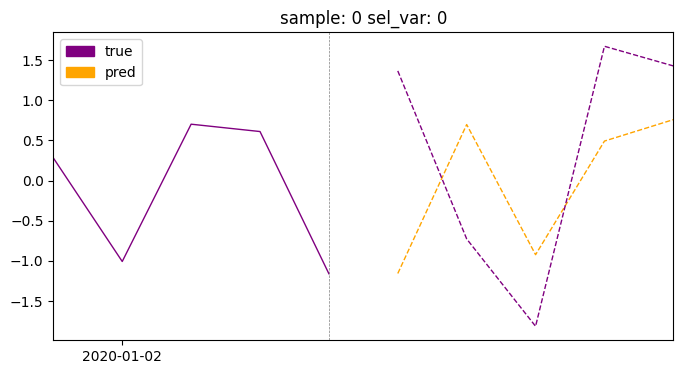

In [40]:
# Test
n_samples = 100
n_vars = 10
lookback = 5
horizon = 5
X_true = np.random.randn(n_samples, n_vars, lookback)
y_true = np.random.randn(n_samples, n_vars, horizon)
y_pred = np.random.randn(n_samples, n_vars, horizon)
# dtms must be a 2D numpy array of datetime objects with the shape 
# (n_samples x (lookback + horizon))
dtms = np.array([pd.date_range('2020-01-01', 
                               periods=lookback + horizon, 
                               freq='D') for i in range(n_samples)])
plot_forecast_2(X_true, y_true, y_pred, dtms=dtms, sel_vars=0, idx=0, 
                figsize=(8, 4), n_samples=1)